## Computer Vision Homework

* Select an image classification dataset of your choice. 
    * Images should be at least 100x100 size.
    * Image datasets are can be very large and we are going to only use a relatively subset.
        * Select Datasets that are either:
            * Reasonable size 
                * You can download in reasonable time 
                * Small enough to not take too much space on your computer
            * Allow you to download a subset.
    * Some example datasets:
        * [Big list from Kaggle](https://www.kaggle.com/datasets?search=image)
        * [Images of buildings, forest, glacier, mountain, sea, street](https://www.kaggle.com/datasets/puneet6060/intel-image-classification)
        * [Indoor Scenes](https://www.kaggle.com/datasets/itsahmad/indoor-scenes-cvpr-2019/data)
        * [Concrete Cracks](https://data.mendeley.com/datasets/5y9wdsg2zt/2)
        * [Architectural Elements](https://old.datahub.io/dataset/architectural-heritage-elements-image-dataset)
        * [Fruits](https://www.kaggle.com/datasets/moltean/fruits)
        * [Scene Understanding](https://www.tensorflow.org/datasets/catalog/sun397)
        * [blood-cells](https://www.kaggle.com/datasets/paultimothymooney/blood-cells)
        * [Cellular Recursion](https://www.kaggle.com/datasets/xhlulu/recursion-cellular-image-classification-224-jpg)
* Create a new notebook for working out the data loader and augmentation (`DataLoader.ipynb`).
    * Follow the Keras examples and this notebook.
    * Setup the dataset for a demonstration of transfer learning
        * Perform any cleaning necessary, like throwing out bad images. 
            * This will be specific to your dataset. 
            * You may discover a problem later, come back and eliminate the bad images here.
        * Select at most 5 classes. Discard the rest of the data.
        * Create a smaller subset of less 100 images per class for training and testing.
        * Figure out how the labels are provided and create a data loader to load the data.
            * If the images are separated into subdirectories, the example above works.
            * If the image information is in a CSV file, easist path is to figure out the way to separate your classes into subdirectories and use the above example.
    * Visualize the images, making sure the data loader is working properly.
    * Create a module which holds the data loader and any other code you may need to reuse.
* Create a new notebook to train a baseline model (`TrainBaseModel.ipynb`)
    * Implement and train a transfer learning model, selecting a model from [Keras Built-in Vision Models](https://keras.io/api/applications/)
    * Make sure you look make the learning curves.
    * Save the model using `model.save()` (see [Keras Model Saving](https://keras.io/guides/serialization_and_saving/)
* Create a new notebook to see effect of data augmentation a baseline model (`TrainBaseModelAugmentation.ipynb`):
    * Add data augmentation.
        * Select at least 3 augmentations that make sense for your datasets (see [Keras Image Augmentation Layers](https://keras.io/api/layers/preprocessing_layers/image_augmentation/)).
        * Visualize the data augmentation to make sure it's working as expected.
    * Train the same model now with data augmentation.
    * Save the new model.   
    * Test if data augmentation is helping:
        * Create a new notebook (`CompareAugmentation.ipynb`)
        * Load the 2 models and compare the ROC curves with and without augmentation.
* Train the three different transfer learning models (`Train-XXXX.ipynb`):
    * Select 2 additional models from [Keras Built-in Vision Models](https://keras.io/api/applications/).
    * Create a new notebook for the each model.
        * Implement and train the model.
        * Make sure you look make the learning curves.
        * Save the model using `model.save` (see [Keras Model Saving](https://keras.io/guides/serialization_and_saving/)
    * Copy the notebook and try a different base model.
* Compare the three models:
    * Create a new notebook (`CompareModels.ipynb`)
    * Load the 3 models.
    * Make a plot comparing the 3 ROC curves of the 3 models on the validation dataset.


### Select dataset
I've selected the Skin Cancer Binary Classification dataset. It has 84 Cancer images (42 Testing, and 42 Training), and it has 204 Non-Cancer images (162 Testing, and 42 Training).

In [2]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

In [3]:
!ls ../../

DATA.4380.Spring.2024  diabetes_predict3.csv
DATA4380_Spring24      diabetes_prediction_dataset.csv
KidneyStoneAnalysis    kagglecatsanddogs_5340.zip
Skin_Data	       playground-series-s4e3
diabetes_predict1.csv  zip_datasets
diabetes_predict2.csv


In [4]:
!ls ../../Skin_Data

Cancer	Non_Cancer  Test  Train


In [5]:
!ls ../../Skin_Data/Cancer

Testing  Training


In [6]:
!ls ../../Skin_Data/Non_Cancer

Testing  Training


In [7]:
# delete corrupted images from cancer and Non-cancer training sets
num_skipped = 0
for folder_name in ("Cancer", "Non_Cancer"):
    folder_path = os.path.join("../../Skin_Data/Train", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 0 images.


In [10]:
# Count the number of corrupted images in the each of the testing sets without deleting
num_skipped = 0
for folder_name in ("Cancer", "Non_Cancer"):
    folder_path = os.path.join("../../Skin_Data/Test", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            #os.remove(fpath)

print(f"Counted {num_skipped} images.")

Counted 0 images.


Now we know that both the traininng and testing sets of each cancer and non-cancer are clean of corrupted images

In [12]:
# Generate a dataset

image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "../../Skin_Data/Train",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 84 files belonging to 2 classes.
Using 68 files for training.
Using 16 files for validation.


2024-04-21 18:24:29.492198: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


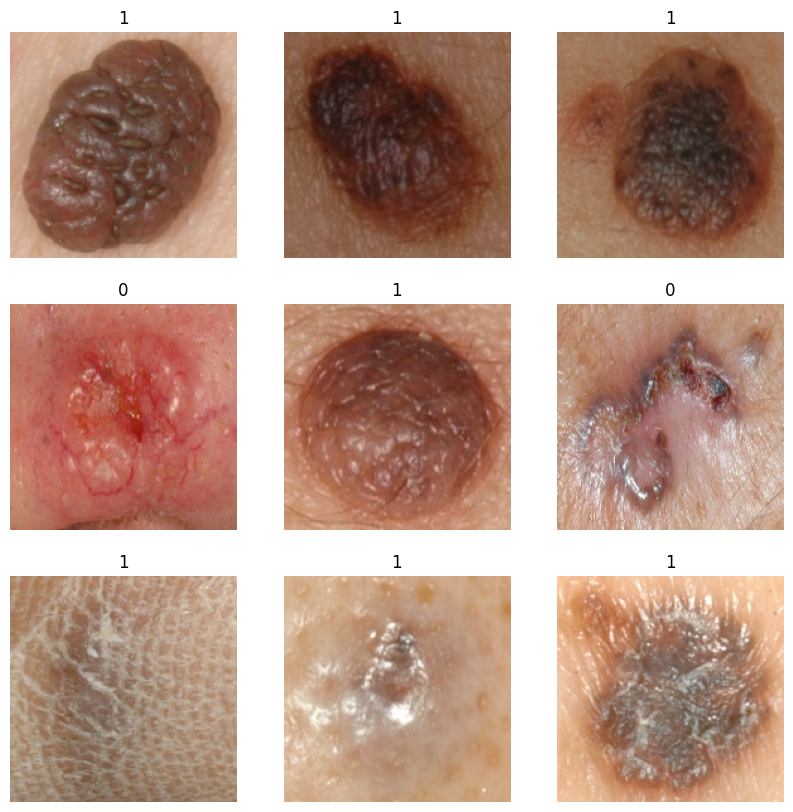

In [13]:
# Visualize the image data

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [17]:
# Augment the data through random aleterations of the images using horizontal random flip, and a random rotation witha factor of (-0.1,0.1)

data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

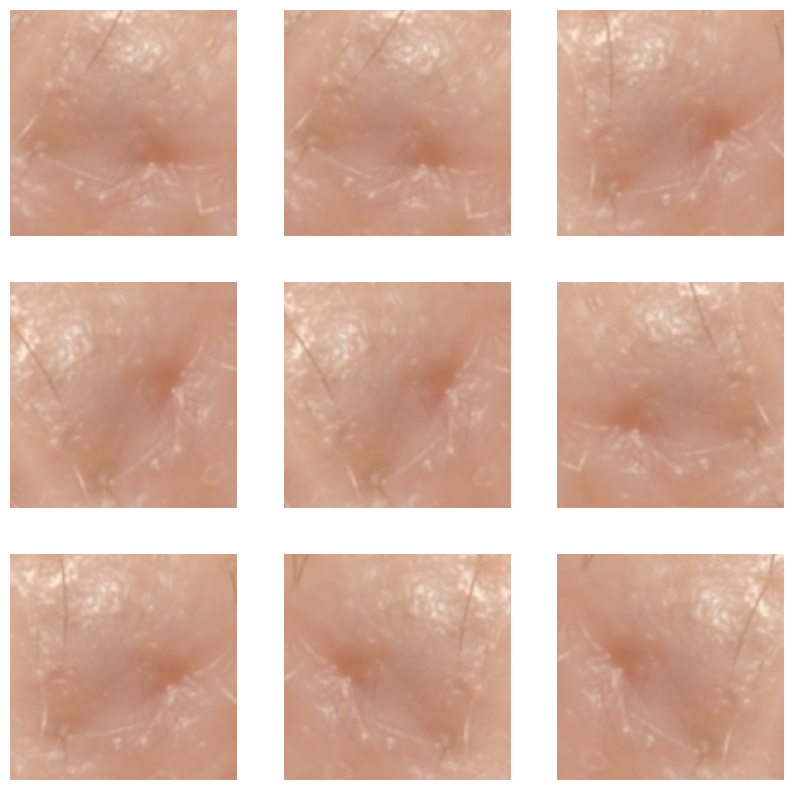

In [18]:
# Visualize some augmented samples

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

### Standardizing the data
Our image are already in a standard size (180x180), as they are being yielded as contiguous float32 batches by our dataset. However, their RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the [0, 1] by using a Rescaling layer at the start of our model.

Since my machine is old, and the hardware does not easily support GPU acceleration, we will use option 2.
Option 2: apply `data_augmentation` preprocessor to the dataset, so as to obtain a dataset that yields batches of augmented images
- With this option, our data augmentation will happen on CPU, asynchronously, and will be buffered before going into the model.

- If we're training on CPU, this is the better option, since it makes data augmentation asynchronous and non-blocking.


In [24]:
# Apply `data_augmentation` to the training images.
# We make sure to use buffered prefetching so we can yield data from disk without having I/O becoming blocking
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

### Build a model
We'll build a small version of the Xception network. We haven't particularly tried to optimize the architecture; if you want to do a systematic search for the best model configuration, consider using [KerasTuner](https://github.com/keras-team/keras-tuner).

Note that:

- We start the model with the `data_augmentation` preprocessor, followed by a `Rescaling` layer.
- We include a `Dropout` layer before the final classification layer.

In [31]:
!pip install --upgrade pydot

Defaulting to user installation because normal site-packages is not writeable


In [32]:
import os
os.environ["PATH"] += os.pathsep + 'path/to/graphviz/bin'


In [35]:
!pip install graphviz

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 1.6 MB/s eta 0:00:00


In [36]:
import pydot
import graphviz


In [37]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


### Training the model

In [40]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25


2024-04-22 14:40:59.806373: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 282009600 exceeds 10% of free system memory.
2024-04-22 14:41:00.691000: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 282009600 exceeds 10% of free system memory.
2024-04-22 14:41:01.507292: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 282009600 exceeds 10% of free system memory.
2024-04-22 14:41:02.596467: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 282009600 exceeds 10% of free system memory.
2024-04-22 14:41:03.448973: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 282009600 exceeds 10% of free system memory.


1/1 ━━━━━━━━━━━━━━━━━━━━ 94s 94s/step - acc: 0.5000 - loss: 0.8550 - val_acc: 0.5000 - val_loss: 0.6931
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 76s 76s/step - acc: 0.5735 - loss: 0.6232 - val_acc: 0.5000 - val_loss: 0.6931
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 76s 76s/step - acc: 0.6618 - loss: 0.5032 - val_acc: 0.5000 - val_loss: 0.6931
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 74s 74s/step - acc: 0.7353 - loss: 0.4531 - val_acc: 0.5000 - val_loss: 0.6932
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 77s 77s/step - acc: 0.7500 - loss: 0.3887 - val_acc: 0.5000 - val_loss: 0.6933
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 75s 75s/step - acc: 0.8088 - loss: 0.3764 - val_acc: 0.5000 - val_loss: 0.6934
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 72s 72s/step - acc: 0.8088 - loss: 0.3297 - val_acc: 0.5000 - val_loss: 0.6935
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 78s 78s/step - acc: 0.8235 - loss: 0.2984 - val_acc: 0.5000 - val_loss: 0.6937
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 80s 80s/step - acc: 0.8676 - loss: 0.2696 - val_acc: 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
This image is 53.69% cancer and 46.31% non-cancer.


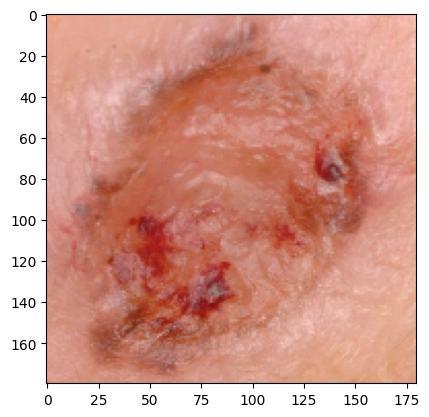

In [43]:
# Run inference on new data. Note that data augmentation and dropout are inactive at inference time.
img = keras.utils.load_img("../../Skin_Data/Test/Cancer/1714-02.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% cancer and {100 * score:.2f}% non-cancer.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
This image is 52.93% cancer and 47.07% non-cancer.


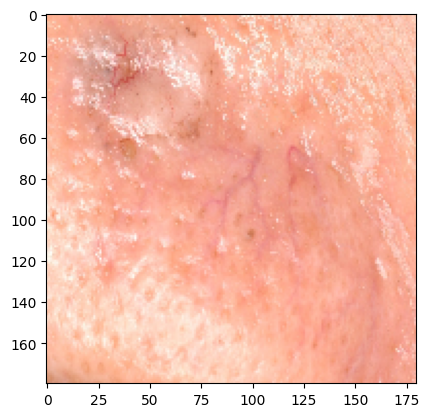

In [44]:
img = keras.utils.load_img("../../Skin_Data/Test/Cancer/1718-2.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(keras.ops.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% cancer and {100 * score:.2f}% non-cancer.")